In [62]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import theano.tensor as tt
import pymc3 as pm

from pymc_marketing.mmm.transformers import geometric_adstock, logistic_saturation
from pymc_marketing.mmm.delayed_saturated_mmm import DelayedSaturatedMMM
from pymc_marketing.mmm.utils import generate_fourier_modes

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [8, 8]
plt.rcParams["figure.dpi"] = 100

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
data = pd.read_csv('C:/Users/norri/Desktop/pymc_data.csv',
    parse_dates=['Date'], index_col='Date')

TV         float64
Radio      float64
Banners    float64
Sales      float64
dtype: object

In [64]:
X = data.drop(columns=['Sales'])
y = data['Sales']

In [65]:
def saturate(x, a):
    return 1 - tt.exp(-a*x)

def carryover(x, strength, length=21):
    w = tt.as_tensor_variable(
        [tt.power(strength, i) for i in range(length)]
    )
    x_lags = tt.stack(
        [tt.concatenate([
            tt.zeros(i),
            x[:x.shape[0]-i]
        ]) for i in range(length)]
    )
    return tt.dot(w, x_lags)

In [66]:
with pm.Model() as mmm:
    channel_contributions = []
    for channel in X.columns:
        coef = pm.Exponential(f'coef_{channel}', lam=0.0001)
        sat = pm.Exponential(f'sat_{channel}', lam=1)
        car = pm.Beta(f'car_{channel}', alpha=2, beta=2)
        channel_data = X[channel].values
        channel_contribution = pm.Deterministic(
            f'contribution_{channel}',
            coef * saturate(
                carryover(
                    channel_data,
                    car
                ),
                sat
            )
        )
        channel_contributions.append(channel_contribution)
    base = pm.Exponential('base', lam=0.0001)
    noise = pm.Exponential('noise', lam=0.0001)
    sales = pm.Normal(
        'sales',
        mu=sum(channel_contributions) + base,
        sigma=noise,
        observed=y
    )
    trace = pm.sample(return_inferencedata=True, tune=3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise, base, car_Banners, sat_Banners, coef_Banners, car_Radio, sat_Radio, coef_Radio, car_TV, sat_TV, coef_TV]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 158 seconds.
The acceptance probability does not match the target. It is 0.8793857930925439, but should be close to 0.8. Try to increase the number of tuning steps.
There were 267 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7173598967902632, but should be close to 0.8. Try to increase the number of tuning steps.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [67]:
az.plot_posterior(trace, var_names=['~contribution'],
    filter_vars='like')

array([[<Axes: title={'center': 'coef_TV'}>,
        <Axes: title={'center': 'sat_TV'}>,
        <Axes: title={'center': 'car_TV'}>],
       [<Axes: title={'center': 'coef_Radio'}>,
        <Axes: title={'center': 'sat_Radio'}>,
        <Axes: title={'center': 'car_Radio'}>],
       [<Axes: title={'center': 'coef_Banners'}>,
        <Axes: title={'center': 'sat_Banners'}>,
        <Axes: title={'center': 'car_Banners'}>],
       [<Axes: title={'center': 'base'}>,
        <Axes: title={'center': 'noise'}>, <Axes: >]], dtype=object)

<Axes: xlabel='coef_TV', ylabel='sat_TV'>

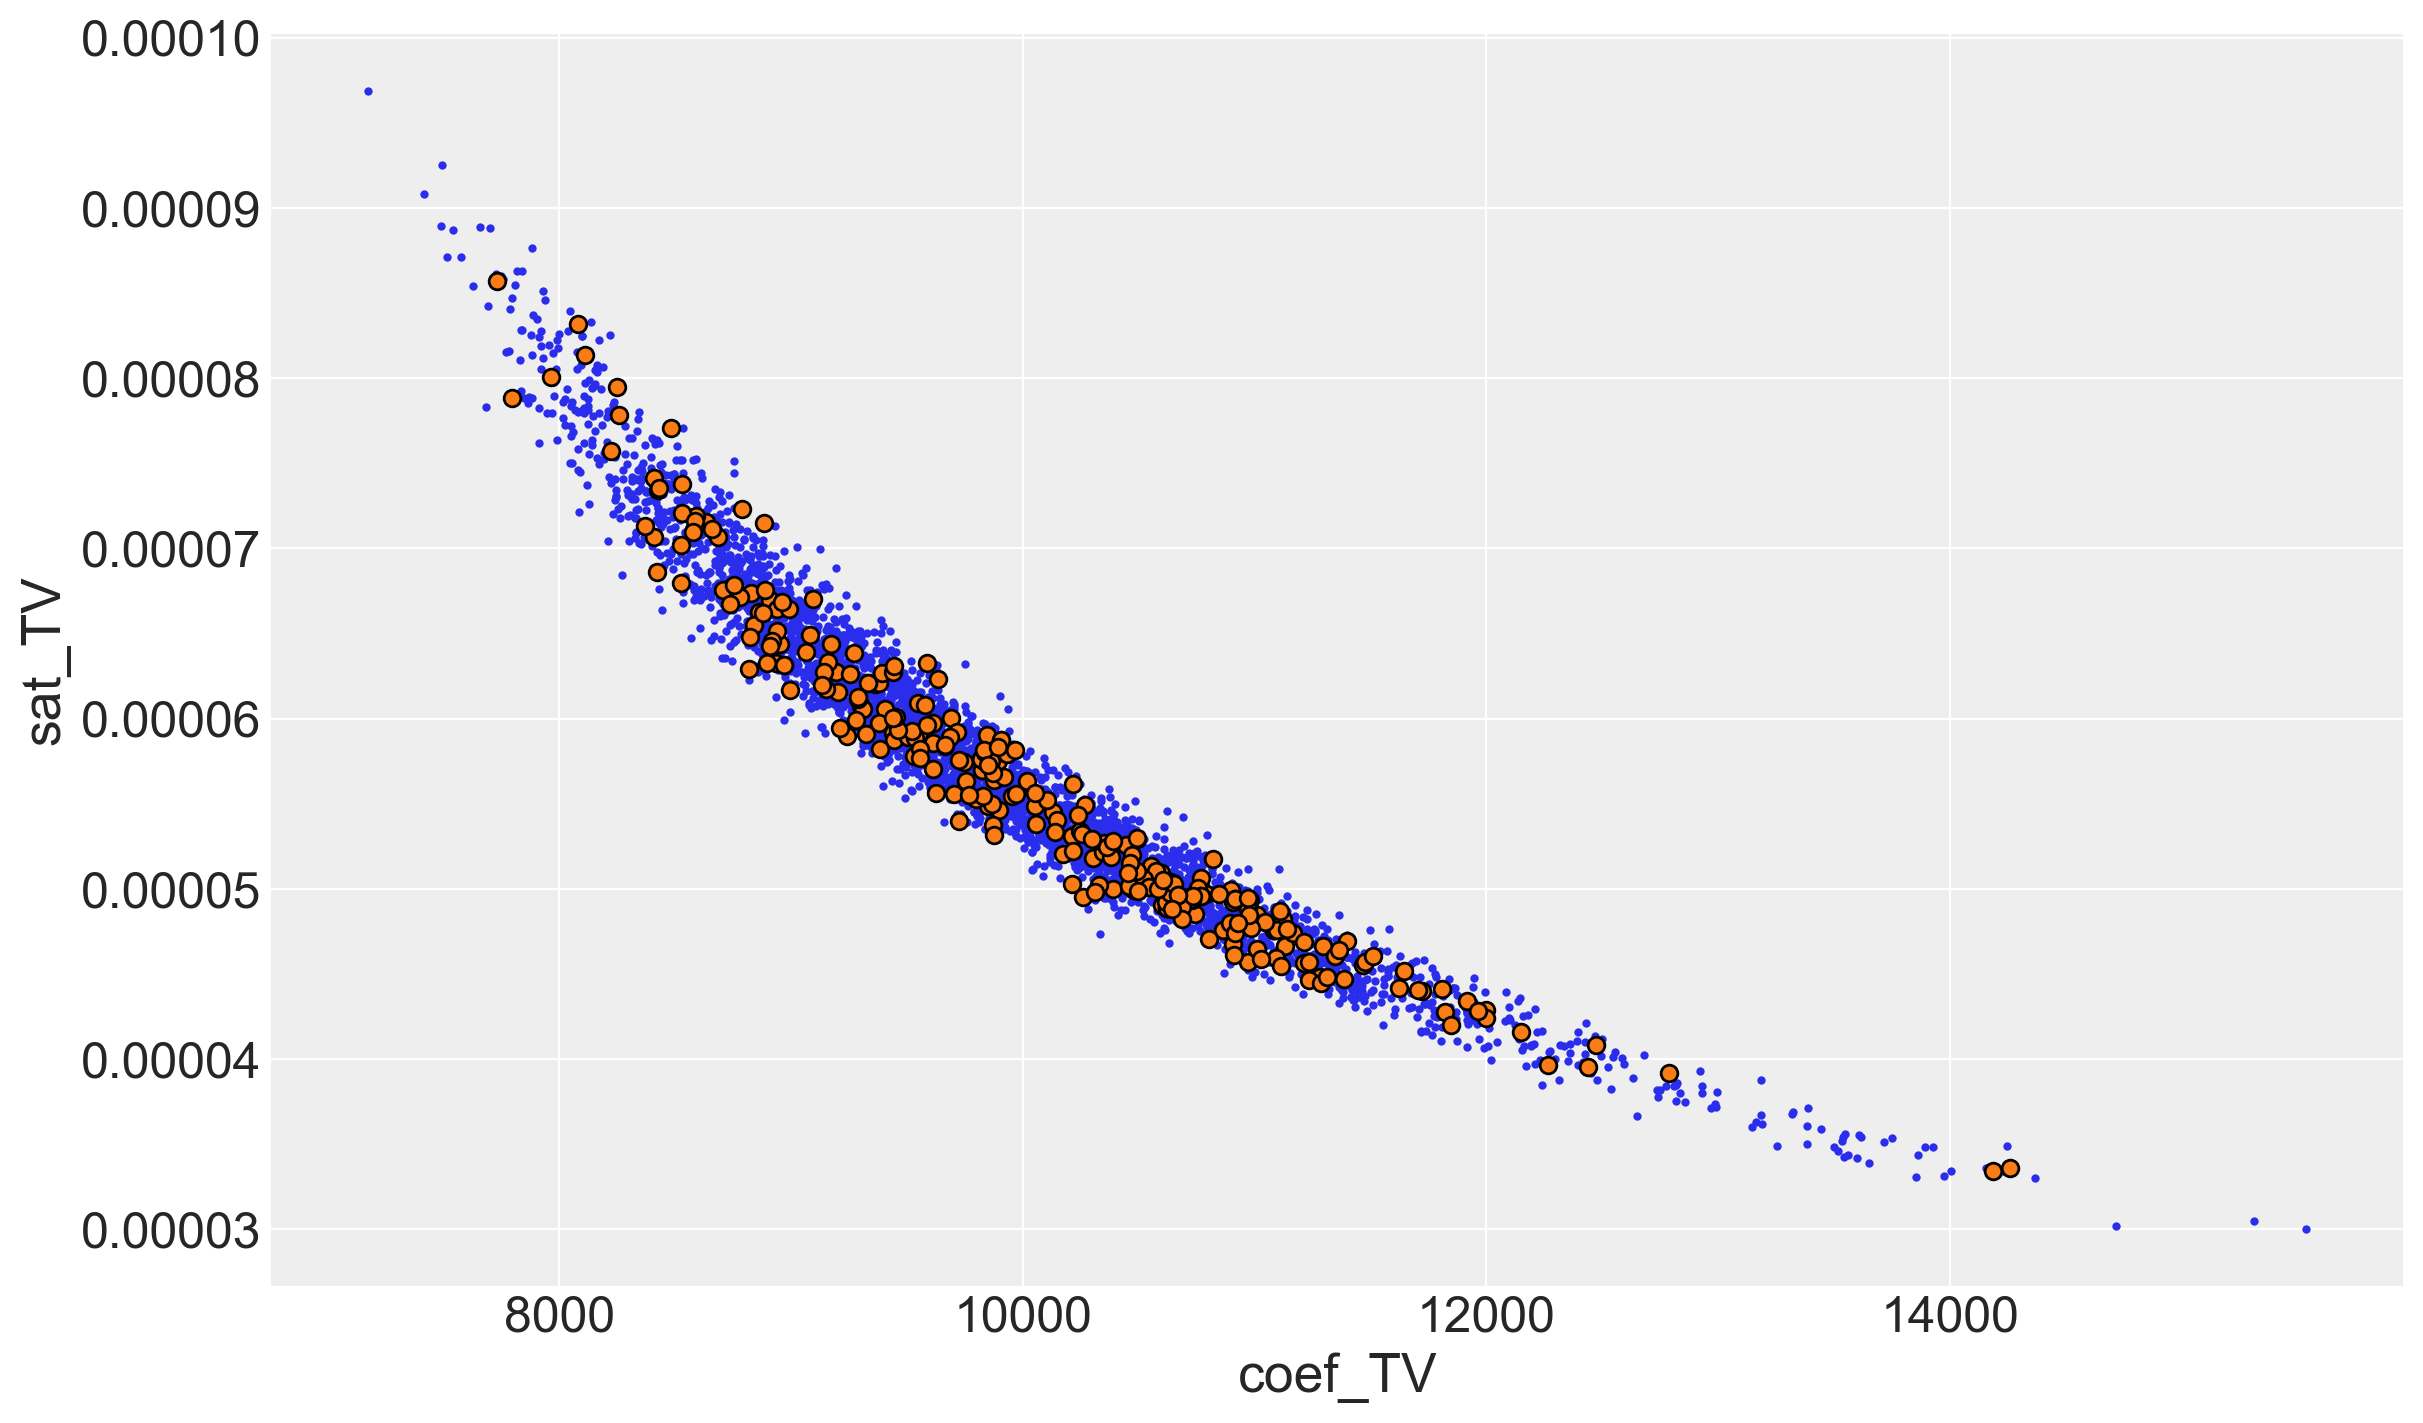

In [68]:
az.plot_pair(trace, var_names=["coef_TV", "sat_TV"],
    divergences=True, textsize=18)

<Axes: xlabel='car_TV', ylabel='sat_TV'>

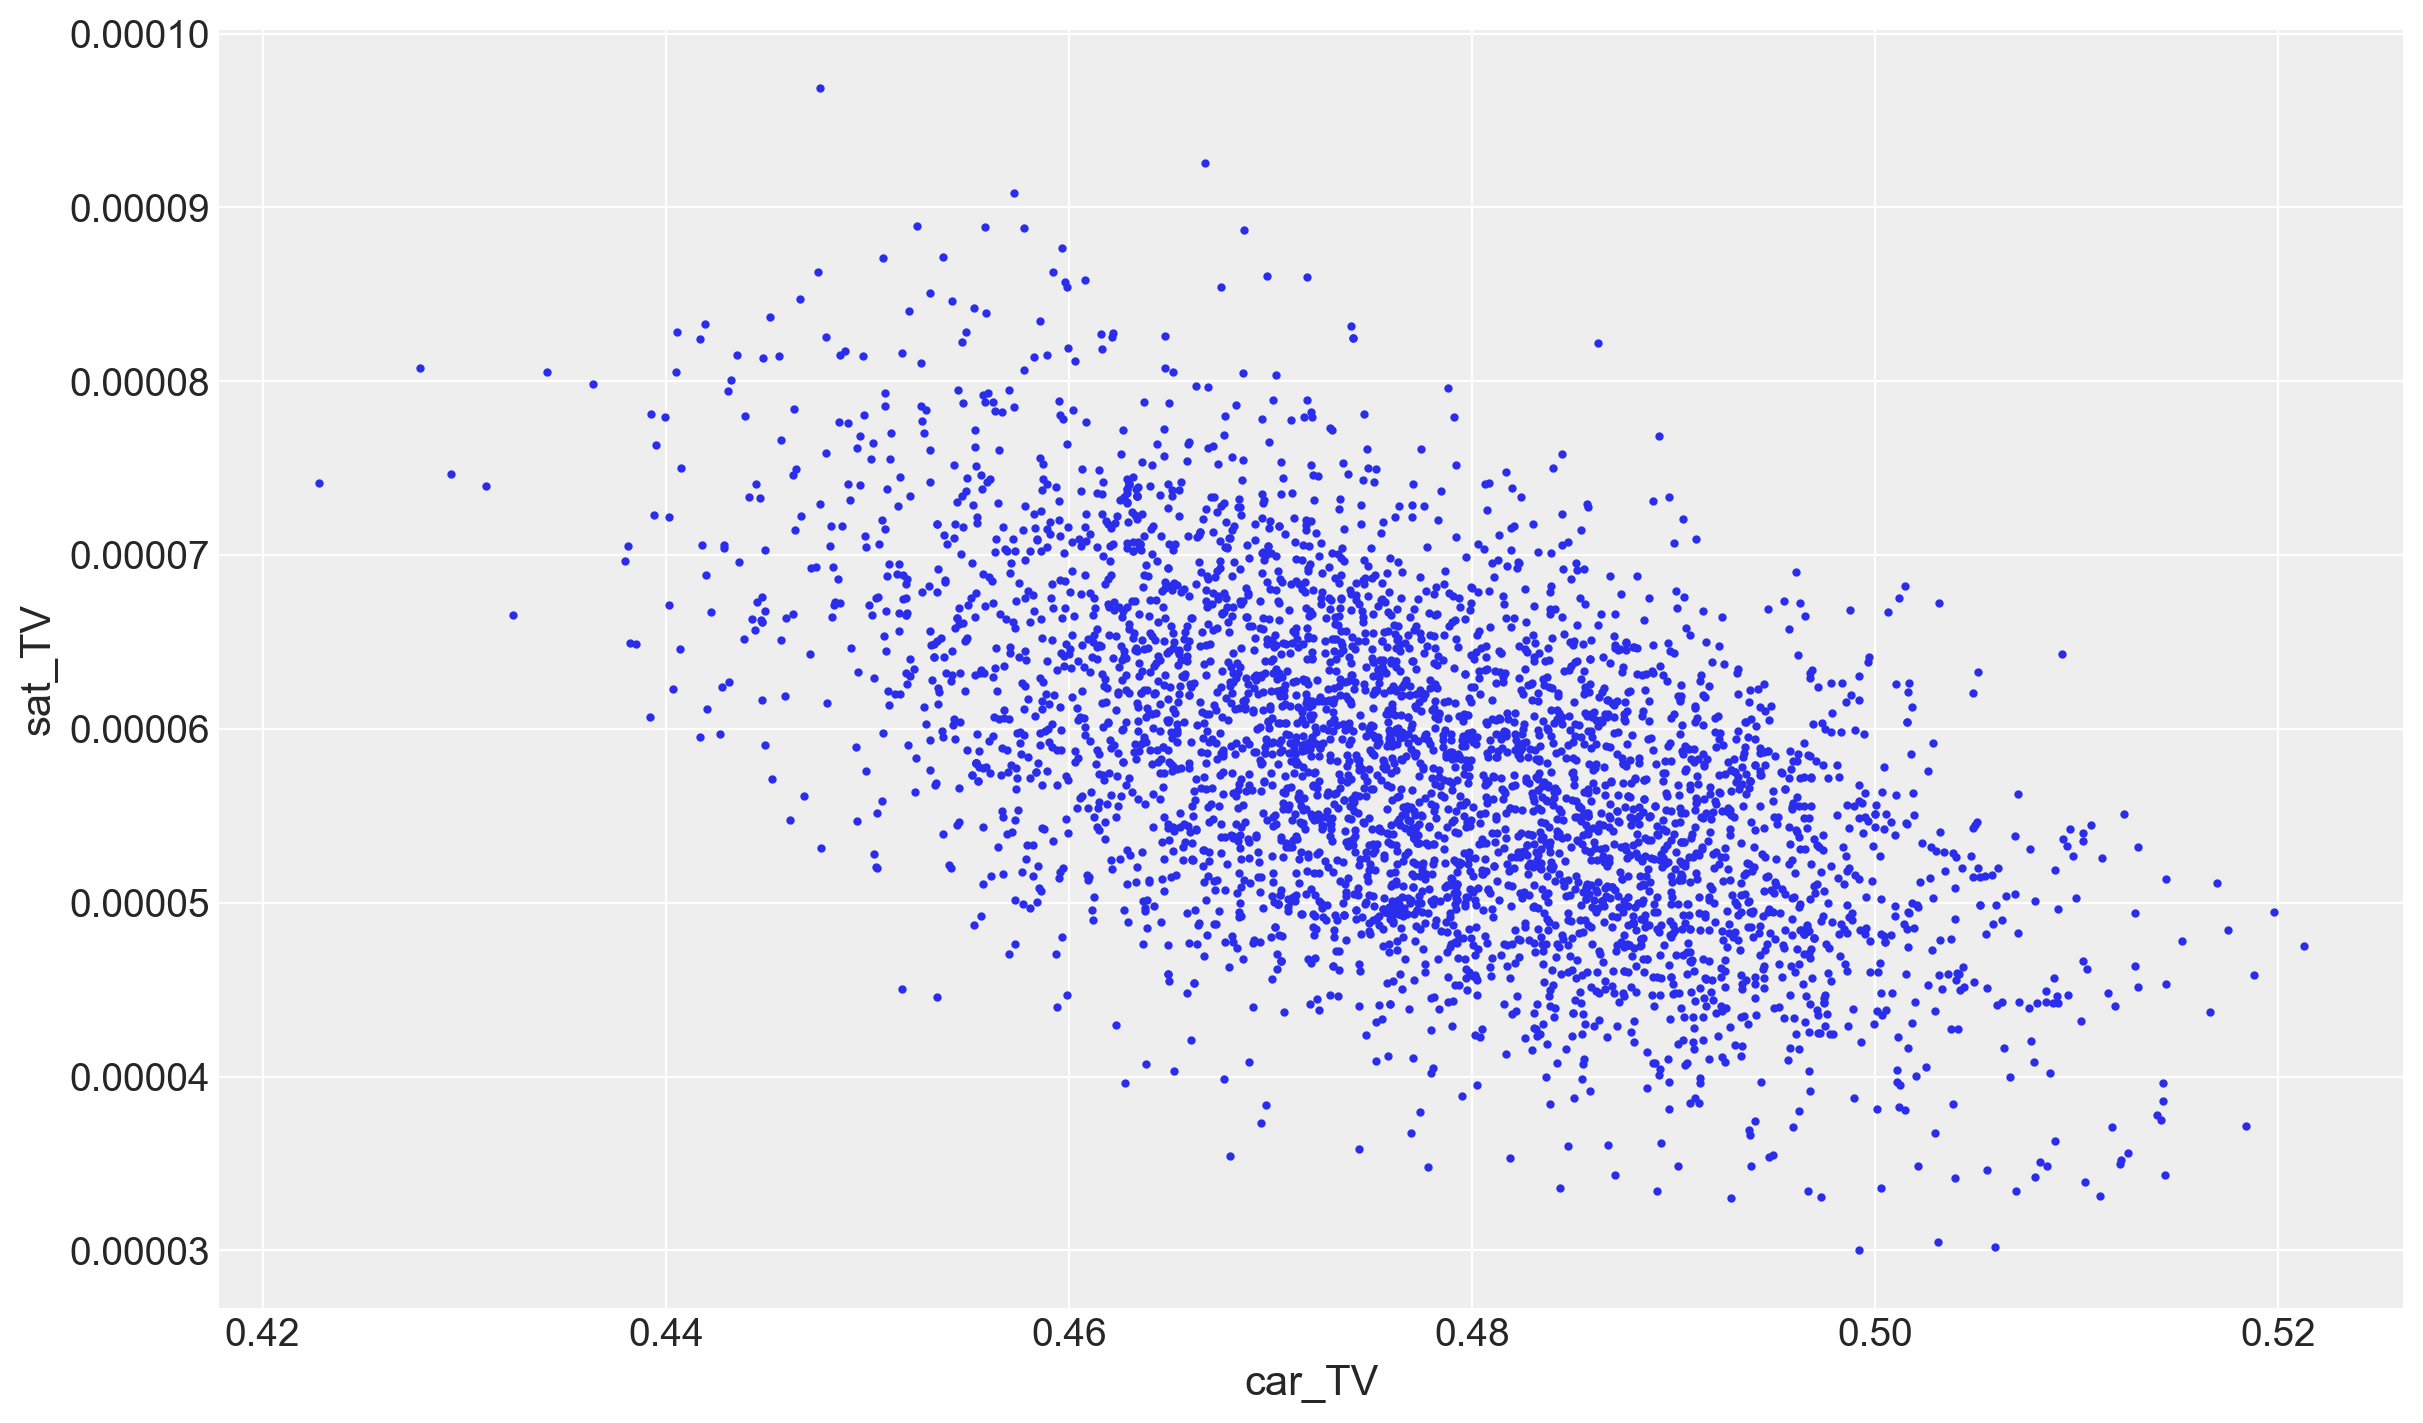

In [69]:
az.plot_pair(trace, var_names=['car_TV', 'sat_TV'],
             divergences=True, textsize=18)

In [70]:
with mmm:
    posterior = pm.sample_posterior_predictive(trace)

TypeError: Do not know how to compute number of samples for trace argument of type <class 'arviz.data.inference_data.InferenceData'>

In [71]:
means = posterior['sales'].mean(0)
stds = posterior['sales'].std(0)

plt.figure(figsize=(20, 8))
plt.plot(y.values, linewidth=2, c='r', label='Observations')
plt.plot(means, linewidth=1, c='b', label='Mean prediction')
plt.fill_between(np.arange(len(y)), means - 2*stds, means + 2*stds, alpha=0.33)
plt.legend()

NameError: name 'posterior' is not defined

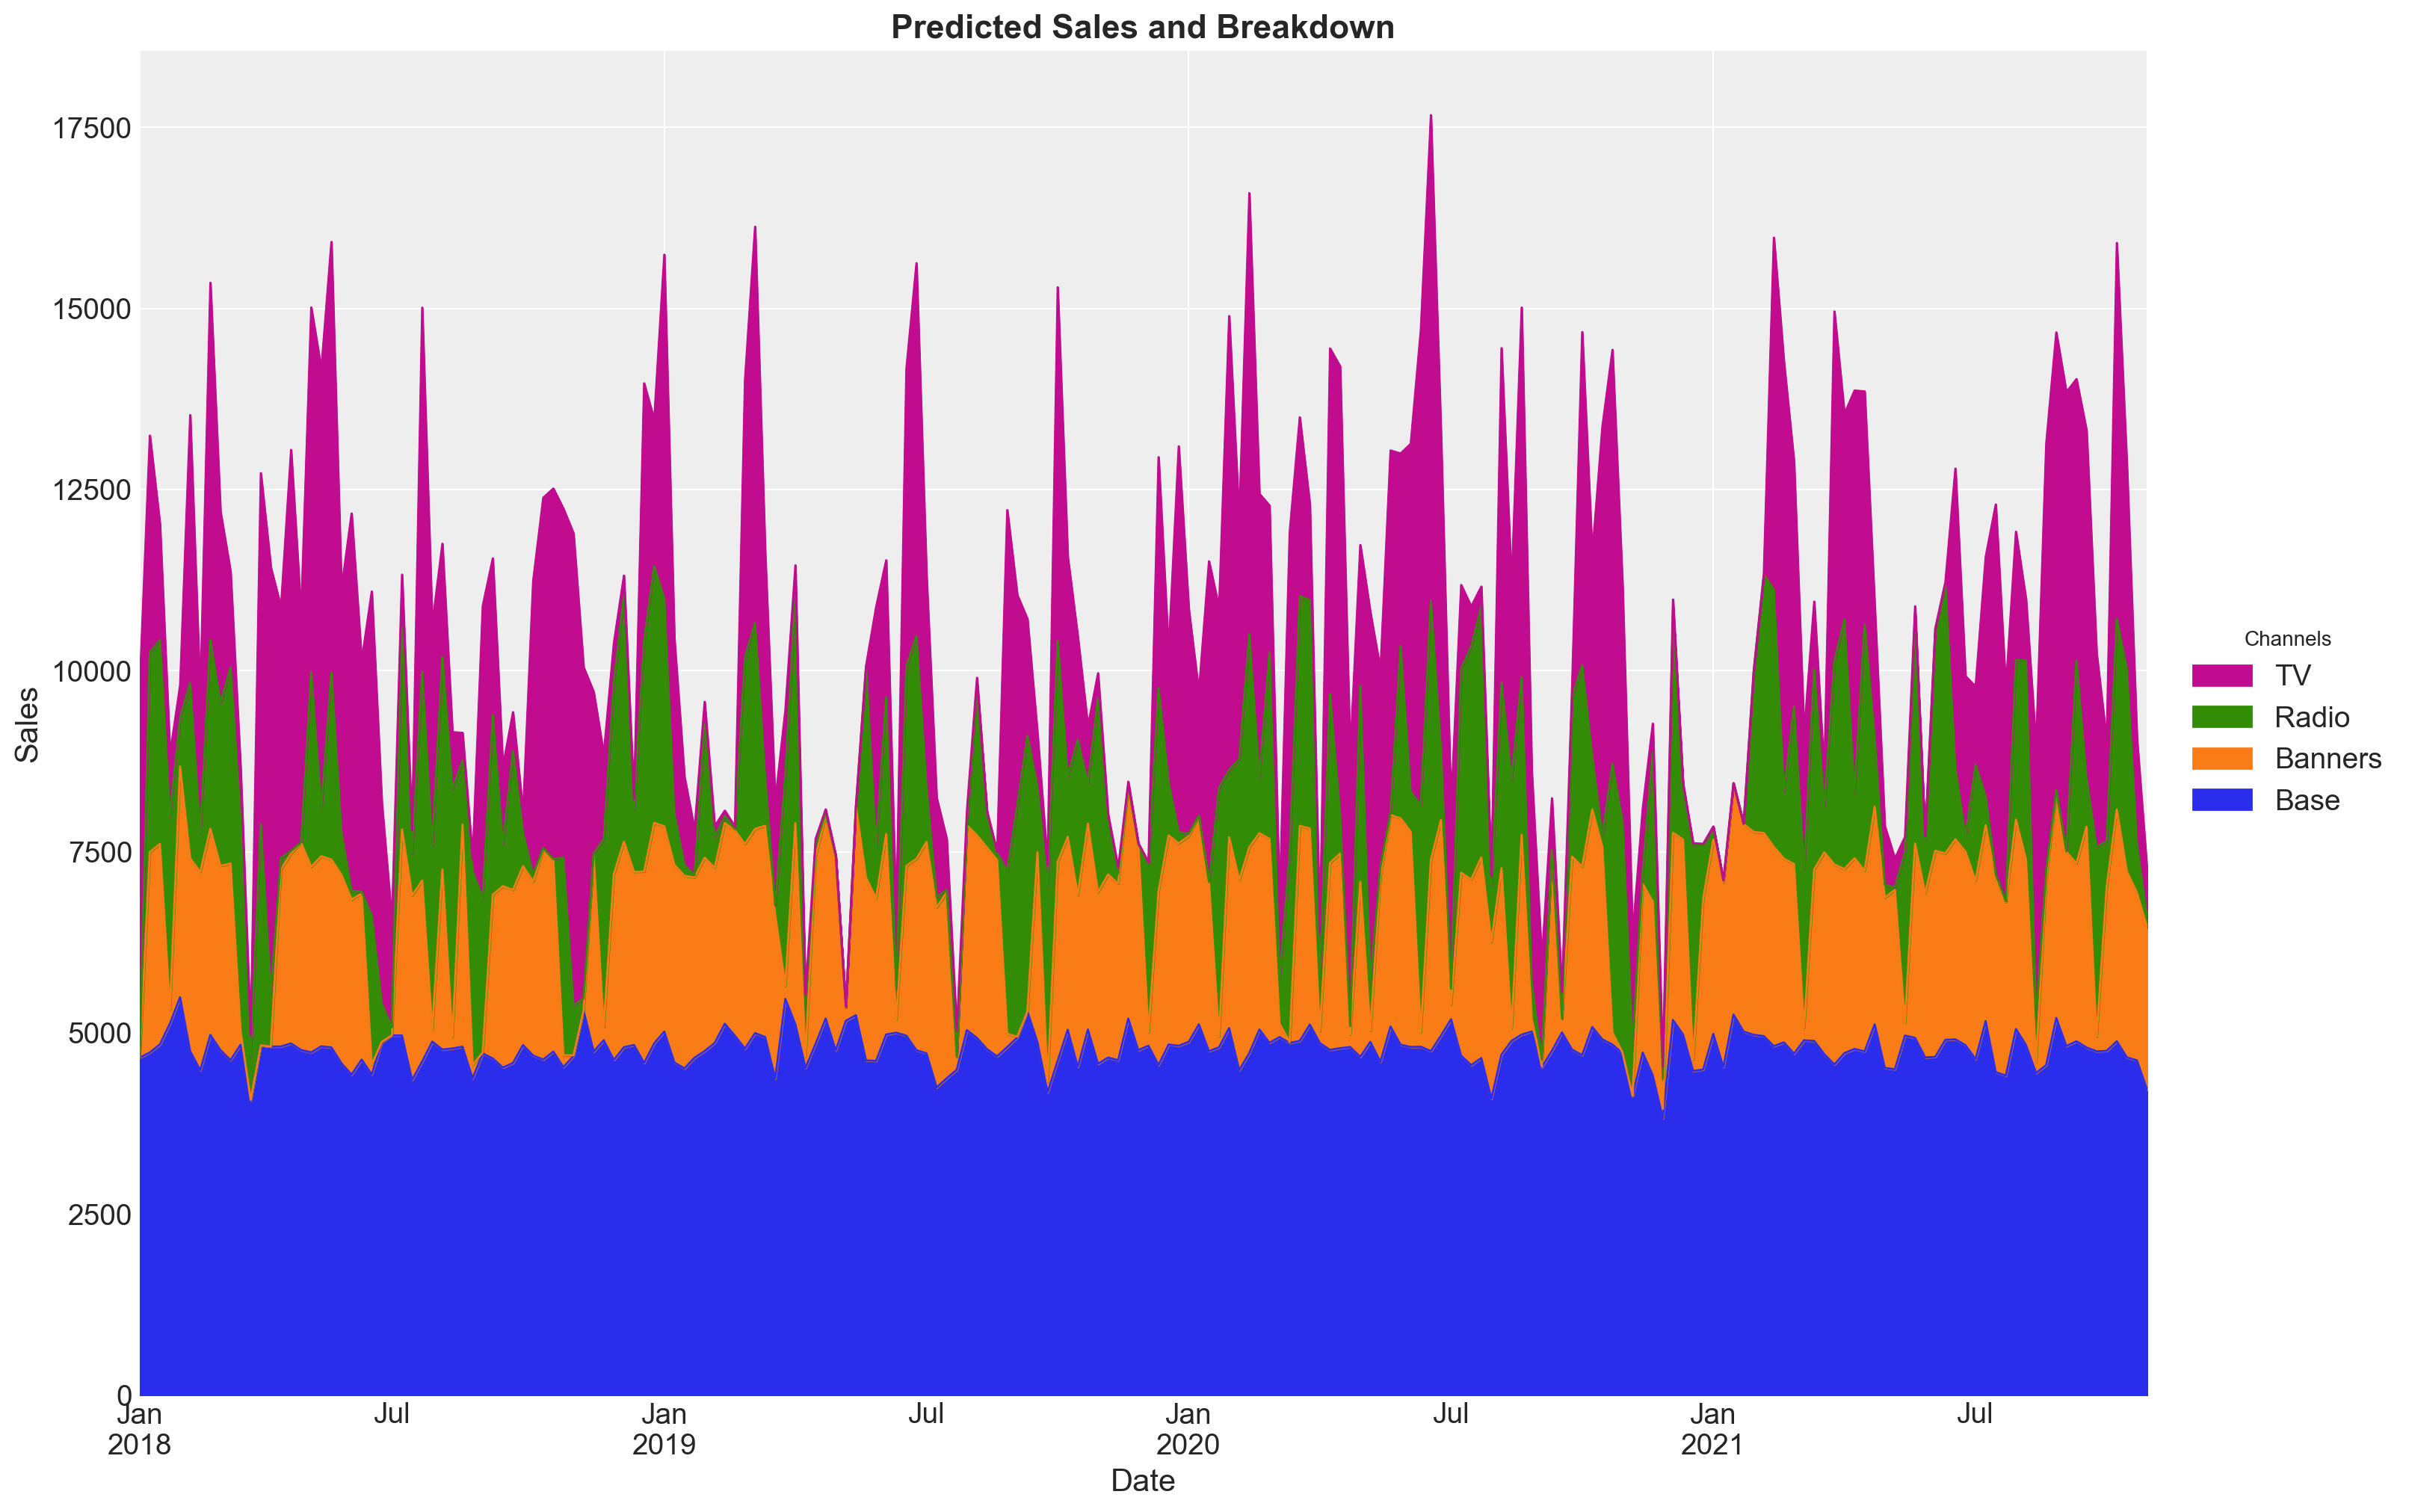

In [72]:
#channel contributions picture, let us take the means to end up with a single value again. Since we introduced some channel contribution #variables in the PyMC3 code, we can easily extract them now using a short compute_mean function.

def compute_mean(trace, channel):
    return (trace
            .posterior[f'contribution_{channel}']
            .values
            .reshape(4000, 200)
            .mean(0)
           )

channels = ['Banners', 'Radio', 'TV']
unadj_contributions = pd.DataFrame(
    {'Base': trace.posterior['base'].values.mean()},
    index=X.index
)

for channel in channels:
    unadj_contributions[channel] = compute_mean(trace, channel)

adj_contributions = (unadj_contributions
                     .div(unadj_contributions.sum(axis=1), axis=0)
                     .mul(y, axis=0)
                    )

ax = (adj_contributions
      .plot.area(
          figsize=(16, 10),
          linewidth=1,
          title='Predicted Sales and Breakdown',
          ylabel='Sales',
          xlabel='Date'
      )
     )

handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles[::-1], labels[::-1],
    title='Channels', loc="center left",
    bbox_to_anchor=(1.01, 0.5)
)

In [74]:
from pymc_marketing.mmm import DelayedSaturatedMMM

data = pd.read_csv('C:/Users/norri/Desktop/pymc_data.csv',
                   parse_dates=['Date'])

mmm = DelayedSaturatedMMM(
    data=data,
    target_column="Sales",
    date_column="Date",
    channel_columns=["TV", "Radio", "Banners"],
)

NotImplementedError: At the moment, convolving with weight arrays that don't have a concrete shape at compile time is not supported.